# Analysis

## Load Data

In [1]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd

from pathlib import Path
from src.db_utils import get_schema_str
from src.database import SqliteDatabase
from src.spider_sparc_preprocess import (
    load_spider_sparc_data,
    process_all_tables, 
    load_samples_spider,
    load_samples_sparc,
    filter_samples_by_count_sparc,
    filter_samples_by_count_spider, 
    process_samples_sparc,
    process_samples_spider, 
    split_train_dev_test,
    save_samples_spider
)

proj_path = Path('.').resolve()

## Spider Dataset

In [2]:
# spider_path = proj_path / 'data' / 'spider'
# tables, train_data, dev_data = load_spider_sparc_data(spider_path, load_test=False)

# with (proj_path / 'data' / 'description.json').open() as f:
#     all_descriptions = json.load(f)
# spider_tables = process_all_tables(tables, descriptions=all_descriptions)

# # # --------------- split_in_domain ----------------
# # all_data = filter_samples_by_count_spider(train_data+dev_data, n=10)
# # # process samples -> {db_id: list of samples}
# # spider_samples = process_samples_spider(all_data, spider_tables, skip=[])
# # # change train/dev by sample
# # train_samples, dev_samples, test_samples = split_train_dev_test(spider_samples, train_ratio=0.8, dev_ratio=0.1)

# # ------------------ split_by_domain ----------------
# def values_flatten(x: dict[str, list]) -> list:
#     return [item for sublist in x.values() for item in sublist]

# train_samples = process_samples_spider(train_data, spider_tables, skip=[])
# train_samples = values_flatten(train_samples)

# dev_samples = process_samples_spider(dev_data, spider_tables, skip=[])
# dev_samples = values_flatten(dev_samples)
# # test_samples = process_samples_spider(test_data, spider_tables, skip=[])
# test_samples = []
# print(f'Number of train: {len(train_samples)} | Number of dev: {len(dev_samples)} | Number of test: {len(test_samples)}')

# save_samples_spider(train_samples, proj_path / 'data' / 'spider_train.json')
# save_samples_spider(dev_samples, proj_path / 'data' / 'spider_dev.json')
# # save_samples_spider(test_samples, proj_path / 'data' / 'spider_test.json')

In [3]:
with (proj_path / 'data' / 'spider' / f'tables.json').open() as f:
    tables = json.load(f)

with (proj_path / 'data' / 'description.json').open() as f:
    all_descriptions = json.load(f)
spider_tables = process_all_tables(tables, descriptions=all_descriptions)

train_samples = load_samples_spider(proj_path / 'data' / 'spider_train.json')
dev_samples = load_samples_spider(proj_path / 'data' / 'spider_dev.json')
# test_samples = load_samples_spider(proj_path / 'data' / 'spider_test.json')
test_samples = []
print(f'Number of train: {len(train_samples)} | Number of dev: {len(dev_samples)} | Number of test: {len(test_samples)}')

Number of train: 7000 | Number of dev: 1034 | Number of test: 0


## Test SQL generation

* gpt-4o-mini
* gemini

In [4]:
import os 
from src.spider_sparc_preprocess import DatabaseModel, SpiderSample
from dotenv import load_dotenv, find_dotenv
from collections import defaultdict
from tqdm import tqdm
from langchain_core.runnables import RunnableSequence
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

_ = load_dotenv(find_dotenv())

class Response(BaseModel):
    full_sql_query: str = Field(description='The full SQL query.')
    rationale: list[str] = Field(description='The step-by-step reasoning to generate the SQL query. Each step has ')

# class Response(BaseModel):
#     output: list[OutputFormat]

template = '''### TASK
You are tasked with generating a SQL query(in a SQLite Database) according to a user input request.
You should work in step-by-step reasoning before coming to the full SQL query.

You will be provided an input NL query.

### SCHEMA
You are working with the following schema in a SQLite Database:
{schema}

### FORMATTING
Your output should be of the following JSON format:
{{
    "rationale": "<list[str]: the step-by-step reasoning to generate the SQL query>",
    "full_sql_query": "<str: the full SQL query>"
}}

### OUTPUT
<INPUT QUERY>: {input_query}
<OUTPUT>: 
'''

prompt = PromptTemplate(
    template=template,
    input_variables=['schema', 'input_query']
)

model_openai = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.0,
)

model = model_openai.with_structured_output(Response)
chain = (prompt | model)

def predict_sql(samples: list[SpiderSample], spider_tables: dict[str, DatabaseModel], chain: RunnableSequence, k: int = 500, file_name: str = 'full_sql_output') -> list[dict]:
    all_full_sql = list()
    for i, data in tqdm(enumerate(samples), total=len(samples)):
        db_schema = get_schema_str(
            schema=spider_tables[data.db_id].db_schema, 
            foreign_keys=spider_tables[data.db_id].foreign_keys,
            col_explanation=spider_tables[data.db_id].col_explanation
        )
        input_data = {'schema': db_schema, 'input_query': data.final.question}
        output = chain.invoke(input=input_data)

        full_sql_output = {}
        full_sql_output['sample_id'] = data.sample_id
        full_sql_output['db_id'] = data.db_id
        full_sql_output['question'] = data.final.question
        full_sql_output['rationale'] = output.rationale
        full_sql_output['pred_sql'] = output.full_sql_query
        full_sql_output['gold_sql'] = data.final.sql
        full_sql_output['source_tables'] = data.final.source_tables
        all_full_sql.append(full_sql_output)

        if len(all_full_sql) == k:
            with open(proj_path / 'experiments' / f'{file_name}_{i//k}.jsonl', 'w') as f:
                for d in all_full_sql:
                    f.write(json.dumps(d) + '\n')
            all_full_sql = list()

    if len(all_full_sql) > 0:
        with open(proj_path / 'experiments' / f'{file_name}_{i//k}.jsonl', 'w') as f:
            for d in all_full_sql:
                f.write(json.dumps(d) + '\n')

In [5]:
# train_predictions = predict_sql(train_samples, spider_tables, chain, k=500, file_name='spider_train')
# dev_predictions = predict_sql(dev_samples, spider_tables, chain, k=500, file_name='spider_dev')
# test_predictions = predict_sql(test_samples, spider_tables, chain, k=500, file_name='spider_test')

In [6]:
def load_predictions(file_pattern: str) -> list[dict]:
    predictions = []
    for p in sorted((proj_path / 'experiments').glob(file_pattern), key=lambda x: int(x.stem.split('_')[-1])):
        with p.open() as f:
            for line in f:
                predictions.append(json.loads(line))
    return predictions

train_predictions = load_predictions('spider_train_*')
dev_predictions = load_predictions('spider_dev_*')

In [7]:
## database execution evaluation
import sqlglot
from src.eval import result_eq, check_if_exists_orderby

def get_output_results(predictions: list[dict], spider_tables: dict[str, DatabaseModel]) -> tuple[list[dict], dict[str, list]]:
    output_results = []
    error_infos = {
        'pred_exec': [],
        'gold_exec': [],
        'python_script': [],
        'result': []
    }

    iterator = tqdm(predictions, total=len(predictions))
    for data in iterator:
        iterator.set_description(f'pred_exec: {len(error_infos["pred_exec"])} | gold_exec: {len(error_infos["gold_exec"])} | python_script: {len(error_infos["python_script"])} | result: {len(error_infos["result"])}')
        sample_id = data['sample_id']
        db_id = data['db_id']
        table = spider_tables[db_id]
        database = SqliteDatabase(str(proj_path / 'data' / 'spider' / 'database' / db_id / f'{db_id}.sqlite'), foreign_keys=table.foreign_keys)
        pred_sql = data['pred_sql'] # sqlglot.parse_one(, read='sqlite').sql()
        gold_sql = data['gold_sql']
        
        error_info = ''
        try:
            pred_result = database.execute(pred_sql, rt_pandas=False)
        except Exception as e:
            pred_result = []
            error_infos['pred_exec'].append(sample_id)
            error_info = 'Predction Execution Error:' + str(e)
            score = 0
        try:
            gold_result = database.execute(gold_sql, rt_pandas=False)
        except Exception as e:
            error_infos['gold_exec'].append(sample_id)
            error_info = 'Gold Execution Error:' + str(e)

        if 'Gold Execution Error' in error_info:
            continue
        elif 'Predction Execution Error' in error_info:
            output_results.append(
                {
                    'sample_id': sample_id, 
                    'db_id': db_id,
                    'score': score,
                    'gold_sql': gold_sql,
                    'pred_sql': pred_sql,
                    'source_tables': data['source_tables'],
                    'error_info': error_info
                }
            )
            continue
        else:
            exists_orderby = check_if_exists_orderby(gold_sql)
            
            try:
                score = int(result_eq(pred_result, gold_result, order_matters=exists_orderby))
            except Exception as e:
                print(f"An error occurred: {e}")
                score = 0
                error_info = 'Python Script Error:' + str(e)
                error_infos['python_script'].append(sample_id)

            if score == 0 and error_info == '':
                error_info = 'Result not equal'
                error_infos['result'].append(sample_id)
            output_results.append(
                {
                    'sample_id': sample_id, 
                    'db_id': db_id,
                    'score': score,
                    'gold_sql': gold_sql,
                    'pred_sql': pred_sql,
                    'source_tables': data['source_tables'],
                    'error_info': error_info
                }
            )

    return output_results, error_infos

# train_output_results, train_errors = get_output_results(train_predictions, spider_tables)
# dev_output_results, dev_errors = get_output_results(dev_predictions, spider_tables)

# eval_path = proj_path / 'experiments' / 'evals'
# if not eval_path.exists():
#     eval_path.mkdir()

# with open(eval_path / 'spider_train_eval.json', 'w') as f:
#     json.dump(train_output_results, f)

# with open(eval_path / 'spider_train_errors.json', 'w') as f:
#     json.dump(train_errors, f)

# with open(eval_path / 'spider_dev_eval.json', 'w') as f:
#     json.dump(dev_output_results, f)

# with open(eval_path / 'spider_dev_errors.json', 'w') as f:
#     json.dump(dev_errors, f)

## Complexity of the SQL

```yaml
val: number(float)/string(str)/sql(dict)
col_unit: (agg_id, col_id, isDistinct(bool))
val_unit: (unit_op, col_unit1, col_unit2)
table_unit: (table_type, col_unit/sql)
cond_unit: (not_op, op_id, val_unit, val1, val2)
condition: [cond_unit1, 'and'/'or', cond_unit2, ...]
sql:
  'select': (isDistinct(bool), [(agg_id, val_unit), (agg_id, val_unit), ...])
  'from': {'table_units': [table_unit1, table_unit2, ...], 'conds': condition}
  'where': condition
  'groupBy': [col_unit1, col_unit2, ...]
  'orderBy': ('asc'/'desc', [val_unit1, val_unit2, ...])
  'having': condition
  'limit': None/limit value
  'intersect': None/sql
  'except': None/sql
  'union': None/sql
```

What operations can be happend after the tables are fixed?

1. Selection (SELECT)
    * Knowing which columns contain the required data. User should know business logics to get the logical calculations.
    * Measure: 1. Number of column selection(include all the selection). 2. Number of logical calculations and aggregated functions.
2. Conditioning (WHERE, HAVING)
    * Filtering the data by some logics. User should know the data of the column like data type, distribution, etc.
    * Measure: 1. Number of conditions used. 2. Number of kinds of conditions used.
3. Aggregation (GROUP BY)
    * Grouping and aggregating data to get a single value. User should know well about the aggregate functions.
    * Measure: Number of aggregations used.
4. Nested Queries (Nested, Set Operation)
    * Complex logics that require multiple queries to be executed. User should know the data of the tables and the relationship between them.
    * Measure: Count of nested queries used.
5. Others: Limiting (LIMIT, OFFSET) & Ordering (ORDER BY)
    * Limiting the number of rows returned / Sorting the data. User should know the data of the columns.
    * Measure: If used limiting or ordering.

* Schema/Data Understanding: Understanding the data stored in the database. This includes the data types, value distributions. (related to the columns and values)
* Business Logic: Domain knowledge, industry-specific calculations, and contextual understanding of values.

### Five functions

* Sigmoid Function: Suitable when you need a smooth, monotonically increasing function.
* Normalized Arctangent Function: Provides a smooth output and handles large input values gracefully.
* Sine Function Adjustment: Good for periodic or oscillatory behavior.
* Cantor Pairing Function: Useful for uniquely encoding pairs of integers into a single number.
* Modulo Operation: Simple and computationally efficient, but not smooth.

Monotonicity: A function is monotonic if it is either entirely non-increasing or non-decreasing.

|Function|Monotonic in a and b?|
|---|---|
|Sigmoid Function|Yes|
|Normalized Arctangent|Yes|
|Sine Function Adjustment|No|
|Cantor Pairing Function|No|
|Modulo Operation|No|

/tmp/ipykernel_28033/2305025448.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


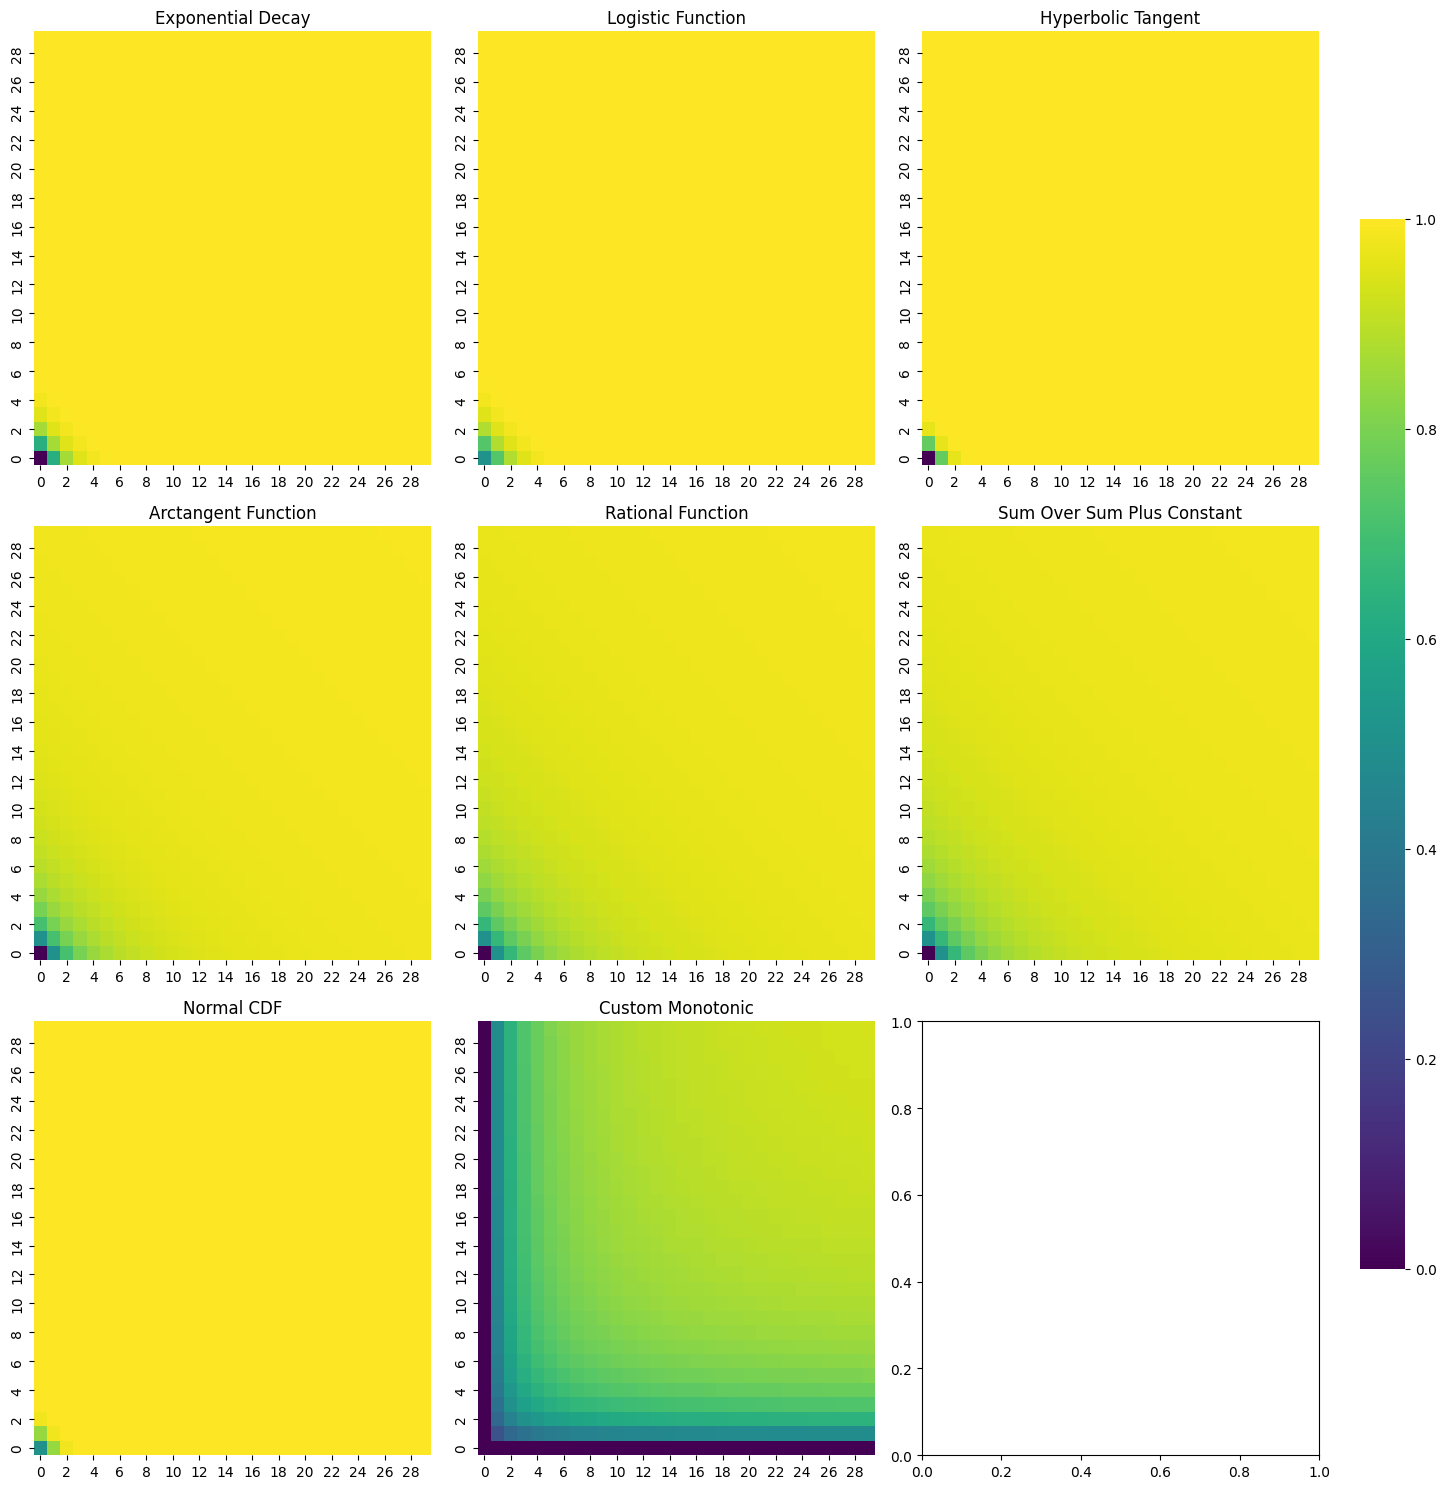

In [90]:
import numpy as np
from scipy.stats import norm

def exponential_decay(a, b, p=1, q=1):
    return 1 - np.exp(- (p * a + q * b))

def logistic_function(a, b, p=1, q=1):
    return 1 / (1 + np.exp(- (p * a + q * b)))

def hyperbolic_tangent(a, b, p=1, q=1):
    return np.tanh(p * a + q * b)

def arctangent_function(a, b, p=1, q=1):
    return np.arctan(p * a + q * b) / (np.pi / 2)

def rational_function(a, b, p=1, q=1):
    return (p * a + q * b) / (1 + p * a + q * b)

def sum_over_sum_plus_constant(a, b, c=1):
    return (a + b) / (a + b + c)

def normal_cdf(a, b, p=1, q=1):
    return norm.cdf(p * a + q * b)

def custom_monotonic(a, b, c=1):
    return (a * b) / ((a + c) * (b + c))

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
cbar_ax = fig.add_axes([.91, .15, .03, .7])

a = np.arange(0, 30)
b = np.arange(0, 30)
a, b = np.meshgrid(a, b)
# a, b = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 10, 100))
for i, (func, name) in enumerate(zip(
    [exponential_decay, logistic_function, hyperbolic_tangent, arctangent_function, rational_function, sum_over_sum_plus_constant, normal_cdf, custom_monotonic],
    ['Exponential Decay', 'Logistic Function', 'Hyperbolic Tangent', 'Arctangent Function', 'Rational Function', 'Sum Over Sum Plus Constant', 'Normal CDF', 'Custom Monotonic'],
)):
    ax = axes[i // 3, i % 3]
    # ax = axes[i]
    z = func(a, b)
    im = sns.heatmap(z, ax=ax, cmap='viridis', cbar=i==0, vmin=0, vmax=1, 
                     cbar_ax=None if i else cbar_ax)
    ax.set_title(name)
    ax.invert_yaxis()
fig.tight_layout(rect=[0, 0, .9, 1])
plt.show()


In [88]:
a

array([[ 0.       ,  0.1010101,  0.2020202, ...,  9.7979798,  9.8989899,
        10.       ],
       [ 0.       ,  0.1010101,  0.2020202, ...,  9.7979798,  9.8989899,
        10.       ],
       [ 0.       ,  0.1010101,  0.2020202, ...,  9.7979798,  9.8989899,
        10.       ],
       ...,
       [ 0.       ,  0.1010101,  0.2020202, ...,  9.7979798,  9.8989899,
        10.       ],
       [ 0.       ,  0.1010101,  0.2020202, ...,  9.7979798,  9.8989899,
        10.       ],
       [ 0.       ,  0.1010101,  0.2020202, ...,  9.7979798,  9.8989899,
        10.       ]])

In [8]:
eval_path = proj_path / 'experiments' / 'evals'

with open(eval_path / 'spider_train_eval.json') as f:
    train_output_results = json.load(f)

with open(eval_path / 'spider_train_errors.json') as f:
    train_errors = json.load(f)

with open(eval_path / 'spider_dev_eval.json') as f:
    dev_output_results = json.load(f)

with open(eval_path / 'spider_dev_errors.json') as f:
    dev_errors = json.load(f)

In [9]:
# import nltk
# nltk.download('punkt_tab')
import pandas as pd 
from src.process_sql import get_sql, get_schema, Schema
from src.eval import get_nestedSQL, Evaluator
import sqlglot
import sqlparse

evaluator = Evaluator()

def is_nested(x: pd.Series, keyword: str, proj_path: Path) -> bool:
    schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
    schema = Schema(schema)
    sql = get_sql(schema, x['gold_sql'])
    if keyword in ('intersect', 'except', 'union'):
        if sql[keyword] is not None:
            return True
    else:
        conds = sql[keyword]['conds'][::2] if keyword == 'from' else sql[keyword][::2]
        for cond_unit in conds:
            if type(cond_unit[3]) is dict:  # val1
                return True
            if type(cond_unit[4]) is dict:  # val2
                return True
    return False

def get_count(sql: dict, category: str, count: int):
    # TODO: need to change the logic here, maybe use sqlglot to parse the sql
    if category == 'selection':
        # total number of columns used in the query
        select = len(sql['select'][1])
        count += len(sql['select'][1])
    elif category == 'condition':
        count += (len(sql['where'][::2]) + len(sql['having'][::2]))
    elif category == 'aggregation':
        count += len(sql['groupBy'])
    elif category == 'ordering':
        count += 1 if sql['orderBy'] else 0
    elif category == 'limitation':
        count += 1 if sql['limit'] is not None else 0
    else:
        raise ValueError(f'Category {category} is not supported.')
    return count 

def get_number_of_components(x: pd.Series, category: str, proj_path: Path) -> int:
    schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
    schema = Schema(schema)
    sql = get_sql(schema, x['gold_sql'])
    count = 0
    count = get_count(sql, category, count)
    if x['is_nested']:
        nested_sql = get_nestedSQL(sql)
        for nested in nested_sql:
            count = get_count(nested, category, count)
    return count

def eval_hardness(x: pd.Series, proj_path: Path) -> str:
    schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
    schema = Schema(schema)
    sql = get_sql(schema, x['gold_sql'])
    return evaluator.eval_hardness(sql)

def process_results(output_results, proj_path: Path, evaluator: Evaluator) -> pd.DataFrame:
    df = pd.DataFrame(output_results)
    df['tbls'] = df['source_tables'].str.join(',')
    df['len_tbls'] = df['source_tables'].apply(len)
    for keyword in ('from', 'where', 'having', 'intersect', 'except', 'union'):
        df[f'is_nested_{keyword}'] = df.apply(is_nested, keyword=keyword, proj_path=proj_path, axis=1)
    df['is_nested'] = df[[f'is_nested_{keyword}' for keyword in ('from', 'where', 'having', 'intersect', 'except', 'union')]].any(axis=1)
    
    for category in ('selection', 'condition', 'aggregation', 'ordering', 'limitation'):
        df[category] = df.apply(get_number_of_components, category=category, proj_path=proj_path, axis=1)
    
    df['hardness'] = df.apply(eval_hardness, proj_path=proj_path, axis=1)
    return df

# df_train_results = process_results(train_output_results, proj_path, evaluator)
# df_dev_results = process_results(dev_output_results, proj_path, evaluator)
# df_train_results.to_csv(eval_path / 'spider_train_eval.csv', index=False)
# df_dev_results.to_csv(eval_path / 'spider_dev_eval.csv', index=False)

print(f'pred_exec: {len(train_errors["pred_exec"])} | gold_exec: {len(train_errors["gold_exec"])} | python_script: {len(train_errors["python_script"])} | result: {len(train_errors["result"])}')
print(f'pred_exec: {len(dev_errors["pred_exec"])} | gold_exec: {len(dev_errors["gold_exec"])} | python_script: {len(dev_errors["python_script"])} | result: {len(dev_errors["result"])}')

pred_exec: 115 | gold_exec: 3 | python_script: 0 | result: 1702
pred_exec: 13 | gold_exec: 2 | python_script: 0 | result: 244


In [10]:
df_train_results = pd.read_csv(eval_path / 'spider_train_eval.csv')
df_dev_results = pd.read_csv(eval_path / 'spider_dev_eval.csv')

In [11]:
# nested vs non-nested
def print_nested_vs_non_nested(df: pd.DataFrame, typ: str = 'train'):
    nested = df[df['is_nested']]
    non_nested = df[~df['is_nested']]
    print(f'Nested {typ}: {nested["score"].mean()*100:.2f}% | Non-Nested {typ}: {non_nested["score"].mean()*100:.2f}%')

print_nested_vs_non_nested(df_train_results, 'train')
print_nested_vs_non_nested(df_dev_results, 'dev')

Nested train: 64.98% | Non-Nested train: 75.56%
Nested dev: 63.06% | Non-Nested dev: 77.49%


In [12]:
def print_each_component(df: pd.DataFrame, category: str, typ: str = 'train'):
    res = df.groupby(['is_nested', category])['score'].agg(['mean', 'count', 'sum'])
    res['mean'] = res['mean']*100
    print(f'{category.capitalize()} {typ}: (is_nested, # of {category})')
    print(res.to_markdown())
    print()

# ('selection', 'condition', 'aggregation', 'ordering', 'limitation')

In [13]:
# selection
print_each_component(df_train_results, 'selection', 'train')
print()
print_each_component(df_dev_results, 'selection', 'dev')

Selection train: (is_nested, # of selection)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (False, 1) | 76.3255 |    3810 |  2908 |
| (False, 2) | 75.7889 |    1743 |  1321 |
| (False, 3) | 70.3896 |     385 |   271 |
| (False, 4) | 55.814  |      43 |    24 |
| (False, 5) | 12.5    |       8 |     1 |
| (True, 2)  | 66.5054 |     827 |   550 |
| (True, 3)  | 72.6415 |     106 |    77 |
| (True, 4)  | 35.5932 |      59 |    21 |
| (True, 5)  |  0      |       4 |     0 |
| (True, 6)  | 58.3333 |      12 |     7 |


Selection dev: (is_nested, # of selection)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (False, 1) | 79.2279 |     544 |   431 |
| (False, 2) | 74.4361 |     266 |   198 |
| (False, 3) | 79.661  |      59 |    47 |
| (False, 4) | 50      |       4 |     2 |
| (False, 6) |  0      |       2 |     0 |
| (True, 2)  | 65.3543 |     127 |    83 |
| (True, 3)  | 42.8571 |      14 |     6 |
| (True

In [14]:
# condition
print_each_component(df_train_results, 'condition', 'train')
print()
print_each_component(df_dev_results, 'condition', 'dev')

Condition train: (is_nested, # of condition)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (False, 0) | 75.9565 |    3032 |  2303 |
| (False, 1) | 76.1555 |    2315 |  1763 |
| (False, 2) | 72.0268 |     597 |   430 |
| (False, 3) | 64.4444 |      45 |    29 |
| (True, 0)  | 74.7475 |      99 |    74 |
| (True, 1)  | 76.8322 |     423 |   325 |
| (True, 2)  | 54.9637 |     413 |   227 |
| (True, 3)  | 36.5854 |      41 |    15 |
| (True, 4)  | 43.75   |      32 |    14 |


Condition dev: (is_nested, # of condition)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (False, 0) | 76.0965 |     456 |   347 |
| (False, 1) | 79.5322 |     342 |   272 |
| (False, 2) | 77.3333 |      75 |    58 |
| (False, 3) | 50      |       2 |     1 |
| (True, 0)  | 80      |      20 |    16 |
| (True, 1)  | 71.0145 |      69 |    49 |
| (True, 2)  | 50.9434 |      53 |    27 |
| (True, 3)  | 55.5556 |       9 |     5 |
| (True

In [15]:
# aggregation
print_each_component(df_train_results, 'aggregation', 'train')
print()
print_each_component(df_dev_results, 'aggregation', 'dev')

Aggregation train: (is_nested, # of aggregation)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (False, 0) | 80.6527 |    4290 |  3460 |
| (False, 1) | 62.8725 |    1678 |  1055 |
| (False, 2) | 50      |      20 |    10 |
| (False, 3) |  0      |       1 |     0 |
| (True, 0)  | 65.4216 |     937 |   613 |
| (True, 1)  | 56.8966 |      58 |    33 |
| (True, 2)  | 69.2308 |      13 |     9 |


Aggregation dev: (is_nested, # of aggregation)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (False, 0) | 83.7705 |     610 |   511 |
| (False, 1) | 63.0189 |     265 |   167 |
| (True, 0)  | 63.4483 |     145 |    92 |
| (True, 1)  | 70      |      10 |     7 |
| (True, 2)  |  0      |       2 |     0 |



In [16]:
# ordering
print_each_component(df_train_results, 'ordering', 'train')
print()
print_each_component(df_dev_results, 'ordering', 'dev')

Ordering train: (is_nested, # of ordering)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (False, 0) | 79.2594 |    4402 |  3489 |
| (False, 1) | 65.2804 |    1587 |  1036 |
| (True, 0)  | 65.3608 |     970 |   634 |
| (True, 1)  | 55.2632 |      38 |    21 |


Ordering dev: (is_nested, # of ordering)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (False, 0) | 81.2693 |     646 |   525 |
| (False, 1) | 66.8122 |     229 |   153 |
| (True, 0)  | 62.9139 |     151 |    95 |
| (True, 1)  | 66.6667 |       6 |     4 |



In [17]:
# limitation
print_each_component(df_train_results, 'limitation', 'train')
print()
print_each_component(df_dev_results, 'limitation', 'dev')

Limitation train: (is_nested, # of limitation)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (False, 0) | 79.6383 |    4921 |  3919 |
| (False, 1) | 56.7416 |    1068 |   606 |
| (True, 0)  | 65.4321 |     972 |   636 |
| (True, 1)  | 52.7778 |      36 |    19 |


Limitation dev: (is_nested, # of limitation)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (False, 0) | 80.7803 |     692 |   559 |
| (False, 1) | 65.0273 |     183 |   119 |
| (True, 0)  | 62.9139 |     151 |    95 |
| (True, 1)  | 66.6667 |       6 |     4 |



In [18]:
# definition from the spider dataset
def print_hardness(df: pd.DataFrame, typ: str = 'train'):
    res = df.groupby(['is_nested', 'hardness'])['score'].agg(
        ['mean', 'count', 'sum']).reindex(['easy', 'medium', 'hard', 'extra'], level=1)
    res['mean'] = res['mean']*100
    print(f'Hardness {typ}: (is_nested, hardness)')
    print(res.to_markdown())

print_hardness(df_train_results, 'train')
print()
print_hardness(df_dev_results, 'dev')

Hardness train: (is_nested, hardness)
|                   |    mean |   count |   sum |
|:------------------|--------:|--------:|------:|
| (False, 'easy')   | 87.3105 |    1781 |  1555 |
| (False, 'medium') | 75.9619 |    2729 |  2073 |
| (False, 'hard')   | 60.5381 |     892 |   540 |
| (False, 'extra')  | 60.8177 |     587 |   357 |
| (True, 'hard')    | 64.6914 |     405 |   262 |
| (True, 'extra')   | 65.1741 |     603 |   393 |

Hardness dev: (is_nested, hardness)
|                   |    mean |   count |   sum |
|:------------------|--------:|--------:|------:|
| (False, 'easy')   | 89.3701 |     254 |   227 |
| (False, 'medium') | 79.6804 |     438 |   349 |
| (False, 'hard')   | 54.3478 |      92 |    50 |
| (False, 'extra')  | 57.1429 |      91 |    52 |
| (True, 'hard')    | 63.6364 |      55 |    35 |
| (True, 'extra')   | 62.7451 |     102 |    64 |


In [19]:
df_train_results.columns

Index(['sample_id', 'db_id', 'score', 'gold_sql', 'pred_sql', 'source_tables',
       'error_info', 'tbls', 'len_tbls', 'is_nested_from', 'is_nested_where',
       'is_nested_having', 'is_nested_intersect', 'is_nested_except',
       'is_nested_union', 'is_nested', 'selection', 'condition', 'aggregation',
       'ordering', 'limitation', 'hardness'],
      dtype='object')

In [107]:
df_train_results.groupby(['is_nested', 'hardness'])['score'].mean()

is_nested  hardness
False      easy        0.873105
           extra       0.608177
           hard        0.605381
           medium      0.759619
True       extra       0.651741
           hard        0.646914
Name: score, dtype: float64

In [47]:
x = df_train_results.loc[df_train_results['aggregation'] == 3, 'gold_sql'].values[0]
print(sqlparse.format(x, reindent=True, keyword_case='upper'))

SELECT Employees.employee_name,
       count(*)
FROM Employees
JOIN Circulation_History ON Circulation_History.employee_id = Employees.employee_id
GROUP BY Circulation_History.document_id,
         Circulation_History.draft_number,
         Circulation_History.copy_number
ORDER BY count(*) DESC
LIMIT 1;


In [32]:
idx = 13
db_id = 'department_management' # 'allergy_1'
target = df_train_results.loc[df_train_results['db_id'] == db_id, 'gold_sql'].values[idx]
pred = df_train_results.loc[df_train_results['db_id'] == db_id, 'pred_sql'].values[idx]
schema = Schema(schema=get_schema(str(proj_path / 'data' / 'spider' / 'database' / db_id / f'{db_id}.sqlite')))
sql = get_sql(schema, target)
# print(evaluator.eval_partial_match(pred, target))

In [37]:
from sqlglot.optimizer import optimize

pred_sql = optimize(sqlglot.parse_one(pred, read='sqlite'))
gold_sql = optimize(sqlglot.parse_one(target, read='sqlite'))

In [25]:
database = SqliteDatabase(str(proj_path / 'data' / 'spider' / 'database' / db_id / f'{db_id}.sqlite'))
pred_result = database.execute(pred, rt_pandas=False)
pred_result

[('California',), ('Delaware',)]

In [27]:
print(pred)

SELECT h1.born_state
FROM department d1
JOIN management m1 ON d1.Department_ID = m1.department_ID
JOIN head h1 ON m1.head_ID = h1.head_ID
WHERE d1.Name = 'Treasury'
UNION
SELECT h2.born_state
FROM department d2
JOIN management m2 ON d2.Department_ID = m2.department_ID
JOIN head h2 ON m2.head_ID = h2.head_ID
WHERE d2.Name = 'Homeland Security';


In [26]:
pred_result = database.execute(target, rt_pandas=False)
pred_result

[('California',)]

In [29]:
print(sqlparse.format(target, reindent=True, keyword_case='upper'))

SELECT T3.born_state
FROM department AS T1
JOIN management AS T2 ON T1.department_id = T2.department_id
JOIN head AS T3 ON T2.head_id = T3.head_id
WHERE T1.name = 'Treasury' INTERSECT
  SELECT T3.born_state
  FROM department AS T1
  JOIN management AS T2 ON T1.department_id = T2.department_id
  JOIN head AS T3 ON T2.head_id = T3.head_id WHERE T1.name = 'Homeland Security'


In [26]:
print(sqlparse.format(x, reindent=True, keyword_case='upper'))

SELECT T3.born_state
FROM department AS T1
JOIN management AS T2 ON T1.department_id = T2.department_id
JOIN head AS T3 ON T2.head_id = T3.head_id
WHERE T1.name = 'Treasury' INTERSECT
  SELECT T3.born_state
  FROM department AS T1
  JOIN management AS T2 ON T1.department_id = T2.department_id
  JOIN head AS T3 ON T2.head_id = T3.head_id WHERE T1.name = 'Homeland Security'


In [32]:
# accuracy
n_train = len(df_train_results)
n_dev = len(df_dev_results)
n_train_correct = df_train_results['score'].sum()
n_dev_correct = df_dev_results['score'].sum()
acc_train = n_train_correct / n_train
acc_dev = n_dev_correct / n_dev
print(f'Train Accuracy: {acc_train*100:.2f}% ({n_train_correct}/{n_train}) | Dev Accuracy: {acc_dev*100:.2f}% ({n_dev_correct}/{n_dev})')

Train Accuracy: 74.03% (5180/6997) | Dev Accuracy: 75.29% (777/1032)


In [33]:
# group by number of tables
len_tbls_train = df_train_results.groupby('len_tbls')['score'].agg(['sum', 'count', 'mean'])
len_tbls_dev = df_dev_results.groupby('len_tbls')['score'].agg(['sum', 'count', 'mean'])

print('Train Accuracy by number of tables:')
for i, x in len_tbls_train.iterrows():
    s = int(x['sum'])
    c = int(x['count'])
    m = x['mean']
    print(f'{i} tables: {m*100:.2f}% ({s}/{c})')

print('Dev Accuracy by number of tables:')
for i, x in len_tbls_dev.iterrows():
    s = int(x['sum'])
    c = int(x['count'])
    m = x['mean']
    print(f'{i} tables: {m*100:.2f}% ({s}/{c})')

Train Accuracy by number of tables:
1 tables: 79.00% (3104/3929)
2 tables: 65.78% (1536/2335)
3 tables: 73.91% (493/667)
4 tables: 75.86% (44/58)
5 tables: 37.50% (3/8)
Dev Accuracy by number of tables:
1 tables: 82.20% (471/573)
2 tables: 69.47% (273/393)
3 tables: 46.67% (28/60)
4 tables: 83.33% (5/6)


In [24]:
# filter only result not equal errors
df_train_result_errors = df_train_results.loc[df_train_results['sample_id'].isin(train_errors['result'])]
df_dev_result_errors = df_dev_results.loc[df_dev_results['sample_id'].isin(dev_errors['result'])]

In [48]:
# group by true-positive, false-negative, false-positive, true-negative

df_count = df_train_results.groupby(['db_id', 'tbls'])['tbls'].count()
df_count = df_count.rename('count').reset_index()


,db_id,tbls,count
0,activity_1,activity,4
1,activity_1,"activity,faculty,faculty_participates_in",8
2,activity_1,"activity,faculty_participates_in",4
3,activity_1,"activity,participates_in",4
4,activity_1,faculty,34
...,...,...,...
1106,workshop_paper,submission,18
1107,workshop_paper,workshop,2
1108,wrestler,elimination,12
1109,wrestler,"elimination,wrestler",10


## Analysis

1. Single table query performance vs multiple table query performance
2. Cofusion matrix for each db_id, calculate the average precision, recall, AUC 

In [10]:
db_id = 'hospital_1'
train_subsamples = list(filter(lambda x: x.db_id == db_id, train_samples))
dev_subsamples = list(filter(lambda x: x.db_id == db_id, dev_samples))
s = get_schema_str(
    schema=spider_tables[db_id].db_schema, 
    foreign_keys=spider_tables[db_id].foreign_keys,
    col_explanation=spider_tables[db_id].col_explanation,
    col_fmt='', skip_type=False)
print(train_subsamples[0].final.question)
print(train_subsamples[0].final.sql)
print(s)

Which department has the largest number of employees?
SELECT name FROM department GROUP BY departmentID ORDER BY count(departmentID) DESC LIMIT 1;
[Table and Columns]
Table Name: Physician
  - EmployeeID(text): Unique identifier for each physician.
  - Name(text): Full name of the physician.
  - Position(text): Job title or role of the physician.
  - SSN(text): Social Security Number of the physician.
Table Name: Department
  - DepartmentID(number): Unique identifier for each department.
  - Name(number): Name of the department.
  - Head(number): Identifier for the head of the department.
Table Name: Affiliated_With
  - Physician(text): Identifier for the physician.
  - Department(text): Identifier for the department.
  - PrimaryAffiliation(text): Indicates if this is the primary affiliation.
Table Name: Procedures
  - Code(text): Unique code for each medical procedure.
  - Name(text): Name of the medical procedure.
  - Cost(text): Cost associated with the procedure.
Table Name: Traine

# Common Interest Detection

## Augment Dataset for training a cross-encoder

* if two questions share the same source table, they are considered as a co-related pair
* using jaccard similarity to label the common interest: 
    * e.g., $q_1$ has three tables $t_1, t_2, t_3$, $q_2$ has two tables $t_1, t_2$, then the jaccard similarity is $2/3$

In [5]:
from collections import defaultdict
from itertools import groupby, combinations, product
from src.spider_sparc_preprocess import SpiderSample, SparcSample

def jaccard_similarity(i_tables: str|set, j_tables: str|set):
    def preprocess(tables: str):
        return set([t.strip() for t in tables.split(',')])
    # Get the number of common tables
    i_set = preprocess(i_tables) if isinstance(i_tables, str) else i_tables
    j_set = preprocess(j_tables) if isinstance(j_tables, str) else j_tables

    common_tables = i_set.intersection(j_set)
    union_tables = i_set.union(j_set)
    return len(common_tables) / len(union_tables)

def curate_samples(samples: list) -> list[dict]:

    dataset = []
    for db_id, group_samples in groupby(samples, key=lambda x: x.db_id):
        # schema_str = get_schema_str(spider_tables[db_id].db_schema, col_fmt='', skip_type=True, remove_meta=True)
        data_dict = defaultdict(list)
        for tbls, samples in groupby(group_samples, key=lambda x: x.final.source_tables):
            tbls = ', '.join(tbls)
            for s in samples:
                data_dict[tbls].append(s.final.question)
        
        for i_tables, j_tables in combinations(data_dict.keys(), 2):
            similarity = jaccard_similarity(i_tables, j_tables)
            i_data = data_dict[i_tables]
            j_data = data_dict[j_tables]
            for i, j in product(i_data, j_data):
                dataset.append(
                    {
                        'db_id': db_id,
                        'sentence1': i,
                        'sentence2': j,
                        'label': similarity,
                        'tables1': i_tables,
                        'tables2': j_tables
                    }
                )
    return dataset

train_dataset = curate_samples(train_samples)
dev_dataset = curate_samples(dev_samples)
test_dataset = curate_samples(test_samples)

with (proj_path / 'data' / 'spider_common_interest_train.json').open('w') as f:
    json.dump(train_dataset, f, indent=4)

with (proj_path / 'data' / 'spider_common_interest_dev.json').open('w') as f:
    json.dump(dev_dataset, f, indent=4)

with (proj_path / 'data' / 'spider_common_interest_test.json').open('w') as f:
    json.dump(test_dataset, f, indent=4)

In [6]:
len(train_dataset), len(dev_dataset), len(test_dataset)

(137797, 1278, 1800)

## Prepare Dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset('json', 
    data_files={'train': str(proj_path / 'data' / 'spider_common_interest_train.json'), 
                'validation': str(proj_path / 'data' / 'spider_common_interest_dev.json'),
                'test': str(proj_path / 'data' / 'spider_common_interest_test.json')})

In [ ]:
from torch.utils.data import DataLoader
from sentence_transformers import CrossEncoder, SentenceTransformer, losses, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.similarity_functions import SimilarityFunction
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import BatchSamplers, SentenceTransformerTrainingArguments


def load_dataset(path: Path):
    with path.open('r') as f:
        dataset = json.load(f)
        
    
    
    return dataset

with (proj_path / 'data' / 'spider_common_interest_train.json').open() as f:
    train_dataset = json.load(f)

with (proj_path / 'data' / 'spider_common_interest_dev.json').open() as f:
    dev_dataset = json.load(f)


model_name = 'all-MiniLM-L6-v2'
train_batch_size = 128  # The larger you select this, the better the results (usually). But it requires more GPU memory
max_seq_length = 75
num_epochs = 1

model = SentenceTransformer(model_name)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
loss = losses.CosineSimilarityLoss()


In [3]:
db_id = 'hospital_1'
train_subsamples = list(filter(lambda x: x.db_id == db_id, train_samples))
dev_subsamples = list(filter(lambda x: x.db_id == db_id, dev_samples))

s = get_schema_str(spider_tables[db_id].db_schema, col_fmt='', skip_type=True)

In [4]:
from itertools import groupby

for k, g in groupby(train_subsamples, key=lambda x: x.final.source_tables):
    if len(k) > 1:
        print(k, len(list(g)))


print()
for k, g in groupby(dev_subsamples, key=lambda x: x.final.source_tables):
    if len(k) > 1:
        print(k, len(list(g)))

# TODO: remove alias from table names

['department', 'physician'] 2
['patient', 'appointment'] 4
['appointment', 'physician'] 4
['department', 'affiliated_with', 'physician'] 2
['patient', 'appointment'] 2
['patient', 'physician', 'prescribes'] 2
['stay', 'patient', 'medication', 'prescribes'] 2
['nurse', 'appointment'] 2
['patient', 'physician'] 4
['block', 'room'] 4
['medication', 'prescribes', 'physician'] 4
['medication', 'prescribes'] 2
['stay', 'patient', 'undergoes'] 2
['nurse', 'undergoes'] 2
['prescribes', 'physician'] 2
['department', 'affiliated_with'] 2
['procedures', 'trained_in', 'physician'] 6

['procedures', 'trained_in', 'physician'] 2
['trained_in', 'procedures', 'physician'] 6
['department', 'affiliated_with', 'physician'] 4
['patient', 'medication', 'prescribes'] 4
['nurse', 'on_call'] 2


Loss: 

* MultipleNegativesRankingLoss

In [ ]:
# https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli_v3.py
# https://www.sbert.net/docs/package_reference/sentence_transformer/losses.html#sentence_transformers.losses.MultipleNegativesRankingLoss
import tqdm
from itertools import groupby, combinations
from src.spider_sparc_preprocess import SpiderSample, SparcSample
from torch.utils.data import DataLoader
from sentence_transformers import CrossEncoder, SentenceTransformer, losses, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.similarity_functions import SimilarityFunction
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import BatchSamplers, SentenceTransformerTrainingArguments
from sentence_transformers.evaluation import BinaryClassificationEvaluator

def curate_dataset(samples: list[SpiderSample|SparcSample]):
    dataset = []
    for db_id, group_samples in groupby(samples, key=lambda x: x.db_id):
        schema_str = get_schema_str(spider_tables[db_id].db_schema, col_fmt='', skip_type=True, remove_meta=True)
        # positive pairs
        for tbls, samples in groupby(group_samples, key=lambda x: x.final.source_tables):
            questions = [schema_str + '\n' + s.final.question for s in samples]
            pairs = list(combinations(questions, 2))
            for p in pairs:
                dataset.append(InputExample(texts=p, label=1))
        # negative pairs

    return dataset

train_data = curate_dataset(train_samples)
dev_data = curate_dataset(dev_samples)

model_name = 'all-MiniLM-L6-v2'
train_batch_size = 128  # The larger you select this, the better the results (usually). But it requires more GPU memory
max_seq_length = 75
num_epochs = 1

model = SentenceTransformer(model_name)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=train_batch_size)

# Use the denoising auto-encoder loss
train_loss = losses.MultipleNegativesRankingLoss(model)

# model.fit(
#     train_objectives=[(train_dataloader, train_loss)], epochs=1, show_progress_bar=True
# )

In [17]:
binary_acc_evaluator = BinaryClassificationEvaluator.from_input_examples(dev_data, name='dev')
results = binary_acc_evaluator(model)

In [8]:
import sqlglot
import sqlglot.expressions as exp
from sqlglot.optimizer import optimize
from sqlglot.optimizer.annotate_types import annotate_types
from sqlglot.optimizer.canonicalize import canonicalize
from sqlglot.optimizer.eliminate_ctes import eliminate_ctes
from sqlglot.optimizer.eliminate_joins import eliminate_joins
from sqlglot.optimizer.eliminate_subqueries import eliminate_subqueries
from sqlglot.optimizer.merge_subqueries import merge_subqueries
from sqlglot.optimizer.normalize import normalize
from sqlglot.optimizer.optimize_joins import optimize_joins
from sqlglot.optimizer.pushdown_predicates import pushdown_predicates
from sqlglot.optimizer.pushdown_projections import pushdown_projections
from sqlglot.optimizer.qualify import qualify
from sqlglot.optimizer.qualify_columns import quote_identifiers
from sqlglot.optimizer.simplify import simplify
from sqlglot.optimizer.unnest_subqueries import unnest_subqueries
from sqlglot.schema import ensure_schema

RULES = (
    # qualify,
    # pushdown_projections,
    # normalize,
    # unnest_subqueries,
    # pushdown_predicates,
    # optimize_joins,
    # eliminate_subqueries,
    # merge_subqueries,
    # eliminate_joins,
    # eliminate_ctes,
    # quote_identifiers,
    # annotate_types,
    # canonicalize,
    # simplify,
)
{"sample_id": 1272, "db_id": "apartment_rentals", "final": 
 {"question": "Show the apartment numbers of apartments with unit status availability of both 0 and 1.", 
"sql": "SELECT T1.apt_number FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id  =  T2.apt_id WHERE T2.available_yn  =  0 INTERSECT SELECT T1.apt_number FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id  =  T2.apt_id WHERE T2.available_yn  =  1", "source_tables": ["t1", "view_unit_status", "t1", "view_unit_status", "apartments"]}}

db_id = 'apartment_rentals'
schema = spider_tables[db_id].db_schema
sql = "SELECT T1.apt_number FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id  =  T2.apt_id WHERE T2.available_yn  =  0 INTERSECT SELECT T1.apt_number FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id  =  T2.apt_id WHERE T2.available_yn  =  1"
sql = sqlglot.parse_one(sql, read='sqlite')
print(sql.sql(pretty=True))
tbls = [x.this.this.lower() for x in list(sql.find_all(exp.Table))]

expression = ' '.join([x.sql() for x in sql.find_all(*[exp.From, exp.Join, exp.Where])])
print(tbls)
print(expression)

SELECT
  T1.apt_number
FROM Apartments AS T1
JOIN View_Unit_Status AS T2
  ON T1.apt_id = T2.apt_id
WHERE
  T2.available_yn = 0
INTERSECT
SELECT
  T1.apt_number
FROM Apartments AS T1
JOIN View_Unit_Status AS T2
  ON T1.apt_id = T2.apt_id
WHERE
  T2.available_yn = 1
['apartments', 'view_unit_status', 'apartments', 'view_unit_status']
FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id = T2.apt_id WHERE T2.available_yn = 0 FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id = T2.apt_id WHERE T2.available_yn = 1


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained('cross-encoder/nli-deberta-v3-large')
tokenizer = AutoTokenizer.from_pretrained('cross-encoder/nli-deberta-v3-large')

features = tokenizer(['A man is eating pizza', 'A black race car starts up in front of a crowd of people.'], ['A man eats something', 'A man is driving down a lonely road.'],  padding=True, truncation=True, return_tensors="pt")

model.eval()
with torch.no_grad():
    scores = model(**features).logits
    label_mapping = ['contradiction', 'entailment', 'neutral']
    labels = [label_mapping[score_max] for score_max in scores.argmax(dim=1)]
    print(labels)


[Table and Columns]
Physician: EmployeeID, Name, Position, SSN
Department: DepartmentID, Name, Head
Affiliated_With: Physician, Department, PrimaryAffiliation
Procedures: Code, Name, Cost
Trained_In: Physician, Treatment, CertificationDate, CertificationExpires
Patient: SSN, Name, Address, Phone, InsuranceID, PCP
Nurse: EmployeeID, Name, Position, Registered, SSN
Appointment: AppointmentID, Patient, PrepNurse, Physician, Start, End, ExaminationRoom
Medication: Code, Name, Brand, Description
Prescribes: Physician, Patient, Medication, Date, Appointment, Dose
Block: BlockFloor, BlockCode
Room: RoomNumber, RoomType, BlockFloor, BlockCode, Unavailable
On_Call: Nurse, BlockFloor, BlockCode, OnCallStart, OnCallEnd
Stay: StayID, Patient, Room, StayStart, StayEnd
Undergoes: Patient, Procedures, Stay, DateUndergoes, Physician, AssistingNurse


In [10]:
spider_tables[train_samples[0].db_id].db_schema

DatabaseModel(db_id='department_management', db_schema={'department': {'Department_ID': 'text', 'Name': 'text', 'Creation': 'text', 'Ranking': 'text', 'Budget_in_Billions': 'text', 'Num_Employees': 'text'}, 'head': {'head_ID': 'number', 'name': 'number', 'born_state': 'number', 'age': 'number'}, 'management': {'department_ID': 'text', 'head_ID': 'text', 'temporary_acting': 'text'}}, col_explanation={'department': {'Department_ID': 'Unique identifier for each department.', 'Name': 'Name of the department.', 'Creation': 'Date when the department was established.', 'Ranking': 'Ranking of the department based on performance.', 'Budget_in_Billions': 'Annual budget allocated to the department in billions.', 'Num_Employees': 'Total number of employees in the department.'}, 'head': {'head_ID': 'Unique identifier for each department head.', 'name': 'Name of the department head.', 'born_state': 'State where the department head was born.', 'age': 'Age of the department head.'}, 'management': {'de

In [ ]:
import sqlglot
import sqlglot.expressions as exp
from sqlglot.optimizer import optimize

def extract_used_table(sql: str, schema: dict) -> list[str]:
    sql = optimize(sqlglot.parse_one(sql, read='sqlite'), schema=schema)
    tbls = [x.this.this for x in list(sql.find_all(exp.Table))]
    return tbls

extract_used_table(train_samples[0].final.sql, spider_tables[train_samples[0].db_id].db_schema)

# Sparc Dataset

In [ ]:
sparc_path = proj_path / 'data' / 'sparc'

tables, train_data, dev_data = load_spider_sparc_data(sparc_path)

with (proj_path / 'db_data' / 'description.json').open() as f:
    all_descriptions = json.load(f)

sparc_tables = process_all_tables(tables, descriptions=all_descriptions)
# filter samples by count, must have at least 5 samples
all_data = filter_samples_by_count_sparc(train_data+dev_data, n=5)
# process samples -> {db_id: list of samples}
sparc_samples = process_samples_sparc(all_data, sparc_tables)
# change train/dev by sample
train_samples, dev_samples = split_train_dev(sparc_samples, ratio=0.8)

print(f'Number of train: {len(train_samples)} | Number of dev: {len(dev_samples)}')

db_id = 'hospital_1'
db_file = str(sparc_path / 'database' / db_id / f'{db_id}.sqlite')
database = SqliteDatabase(db_file, foreign_keys=sparc_tables[db_id].foreign_keys)
print(database.table_cols.keys())
database.execute('SELECT * FROM Department LIMIT 5;')

## Workload Analysis

In [7]:
from src.spider_sparc_preprocess import SparcSample, QuestionSQL

def format_interactions(interactions: list[QuestionSQL]) -> str:
    workload = ''
    for i, interaction in enumerate(interactions):
        workload += f'[{i}-Question] {interaction.question}\n[{i}-SQL]: {interaction.sql}\n'
    return workload.strip()

with (proj_path / 'db_data' / 'sparc_description.json').open() as f:
    all_descriptions = json.load(f)

db_id = 'hospital_1'
train_subsamples = list(filter(lambda x: x.db_id == db_id, train_samples))
dev_subsamples = list(filter(lambda x: x.db_id == db_id, dev_samples))

table = sparc_tables[db_id]
col_explanation = all_descriptions[db_id]
# create schema string
schema_str = get_schema_str(
    schema=table.db_schema, 
    foreign_keys=table.foreign_keys,
    primary_keys=table.primary_keys,
    col_explanation=col_explanation
)  
database = SqliteDatabase(str(sparc_path / 'database' / db_id / f'{db_id}.sqlite'), foreign_keys=table.foreign_keys)

data = train_samples[2]
workload = format_interactions(data.interactions)
print(workload, '\n')
print(f'[Final]\nQuestion: {data.final.question}\nSQL: {data.final.sql}\n')

[0-Question] How many employees does each department have?
[0-SQL]: SELECT count(departmentID) FROM department GROUP BY departmentID
[1-Question] Which department has the smallest number of employees?
[1-SQL]: SELECT * FROM department GROUP BY departmentID ORDER BY count(departmentID) LIMIT 1;
[2-Question] Tell me the name and position of the head of this department.
[2-SQL]: SELECT T2.name ,  T2.position FROM department AS T1 JOIN physician AS T2 ON T1.head  =  T2.EmployeeID GROUP BY departmentID ORDER BY count(departmentID) LIMIT 1; 

[Final]
Question: Find the name and position of the head of the department with the least employees.
SQL: SELECT T2.name ,  T2.position FROM department AS T1 JOIN physician AS T2 ON T1.head  =  T2.EmployeeID GROUP BY departmentID ORDER BY count(departmentID) LIMIT 1;



In [8]:
database.execute(data.interactions[0].sql)

,count(departmentID)
0,1
1,1
2,1


In [9]:
database.execute(data.interactions[1].sql)

,DepartmentID,Name,Head
0,1,General Medicine,4


In [10]:
database.execute(data.interactions[2].sql)

,Name,Position
0,Percival Cox,Senior Attending Physician


In [11]:
database.execute(data.final.sql)

,Name,Position
0,Percival Cox,Senior Attending Physician


### 1. Common table extraction

* find the common table used in the question-sql workloads: All joined tables

In [12]:
import sqlglot
import sqlglot.expressions as exp
from sqlglot.diff import Keep
from sqlglot.optimizer import optimize
from collections import Counter

def extract_table_expression(x: QuestionSQL, schema: dict) -> str:
    sql = optimize(sqlglot.parse_one(x.sql, read='sqlite'), schema=schema)
    tbls = [x.this.this for x in list(sql.find_all(exp.Table))]
    expression = ' '.join([x.sql() for x in sql.find_all(*[exp.From, exp.Join])])
    return ','.join(tbls), expression

def get_sources(data: SparcSample, schema: dict) -> list[tuple[str, list[str]]]:
    sources = []
    for x in data.interactions:
        tbls, expression = extract_table_expression(x, schema)
        sources.append({'question': x.question, 'table': tbls, 'expression': expression})
    return sources

db_id = 'hospital_1'
train_subsamples = list(filter(lambda x: x.db_id == db_id, train_samples))
dev_subsamples = list(filter(lambda x: x.db_id == db_id, dev_samples))
table = sparc_tables[db_id]
database = SqliteDatabase(str(sparc_path / 'database' / db_id / f'{db_id}.sqlite'), foreign_keys=table.foreign_keys)

used_tables = Counter()
for data in train_subsamples:
    sources = get_sources(data, table.db_schema)
    used = [x['table'] for x in sources]
    used_tables.update(used)

print(f'# of train workloads: {len(train_subsamples)}')
print(f'# of used tables: {len(used_tables)}\n-----------------')
for k, v in used_tables.most_common():
    print(f'{k}: {v}')

# of train workloads: 25
# of used tables: 22
-----------------
appointment: 9
department: 7
physician: 6
stay: 6
physician,patient: 6
block,room: 4
room: 4
medication: 3
appointment,patient: 2
appointment,physician: 2
physician,affiliated_with,department: 2
nurse,appointment: 2
prescribes,medication: 2
physician,prescribes,medication: 2
department,physician: 1
physician,appointment,physician: 1
patient,appointment: 1
prescribes,physician: 1
patient,prescribes,physician: 1
stay,patient,prescribes: 1
stay,patient,prescribes,medication: 1
medication,prescribes: 1


In [21]:
# a nested query
sql = """
SELECT * FROM (
    SELECT * FROM Department
) AS A
WHERE A.department_id = 1;
"""

sql = sqlglot.parse_one(sql, read='sqlite')
tbls = [x.this.this for x in list(sql.find_all(exp.Table))]
expression = ' '.join([x.sql() for x in sql.find_all(*[exp.From, exp.Join])])

### 2. Extract Term - Expression

In [18]:
import os 
from dotenv import load_dotenv, find_dotenv
from collections import defaultdict
from tqdm import tqdm
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

_ = load_dotenv(find_dotenv())

In [31]:
class TermExpressions(BaseModel):
    rationale: str = Field(description='The reasoning behind the decision.')
    index: int = Field(description='Index of the question-sql pair.')
    term: str = Field(description='A declarative form of the natural language term.')
    expression: str = Field(description='SQL expression that refers to the term.')

class Response(BaseModel):
    output: list[TermExpressions]
    
template = '''### Task
You are tasked with identifying the partial term - partial expression relationship to represent the common interest query.
You will be proveded several pairs of question and SQL with index. Do not extract the FROM and JOIN clauses.
There could be multiple terms and expressions in a single question-SQL pair.

### Formatting
Your output should be of the following list of JSON format:
[
    {{
        "rationale": <str: the reasoning behind decision>,
        "index: <int: the index of the question-sql pair>,
        "term": <str: a partial natural language term>,
        "expression" : <str: a partial SQL expression that refer to the term>,
    }}, ...
]


### Output
<QUESTION-SQL>:\n{workload}
<OUTPUT>: 
'''

prompt = PromptTemplate(
    template=template,
    input_variables=['workload']
)

model_openai = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.0,
)

model = model_openai.with_structured_output(Response)
chain = (prompt | model)

all_term_expression = defaultdict(list)
for data in tqdm(train_subsamples, total=len(train_subsamples)):
    workload = format_interactions(data.interactions)
    term_expression = chain.invoke(input={'workload': workload}).output
    all_term_expression[data.sample_id] = term_expression
    # for x in data.interactions:
    #     input_data = {'question': x.question, 'sql': x.sql}
    #     term_expression = chain.invoke(input=input_data).output
    #     tbls, _ = extract_table_expression(x, table.db_schema)
    #     all_term_expression[tbls].append(term_expression)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:21<00:00,  3.27s/it]


In [35]:
for sample_id, term_exps in all_term_expression.items():
    for x in term_exps:
        print(f'[Sample {sample_id:02d}-{x.index}]: {x.term} - {x.expression}')

[Sample 00-0]: employees - count(departmentID)
[Sample 00-0]: department - GROUP BY departmentID
[Sample 00-1]: most employees - ORDER BY count(departmentID) DESC LIMIT 1
[Sample 00-1]: department name - name
[Sample 00-1]: department - GROUP BY departmentID
[Sample 01-0]: employees - count(departmentID)
[Sample 01-0]: department - GROUP BY departmentID
[Sample 01-1]: least employees - ORDER BY count(departmentID) LIMIT 1
[Sample 01-1]: department - GROUP BY departmentID
[Sample 01-2]: head - head
[Sample 01-2]: department - GROUP BY departmentID
[Sample 02-0]: employees - count(departmentID)
[Sample 02-0]: department - GROUP BY departmentID
[Sample 02-1]: smallest number of employees - ORDER BY count(departmentID) LIMIT 1
[Sample 02-1]: department - GROUP BY departmentID
[Sample 02-2]: name - T2.name
[Sample 02-2]: position - T2.position
[Sample 02-2]: department - GROUP BY departmentID
[Sample 03-0]: patient id - patient
[Sample 03-1]: names of patients - name
[Sample 03-1]: appointm

In [13]:
with (proj_path / 'db_data' / 'sparc_description.json').open() as f:
    all_descriptions = json.load(f)

print(get_schema_str(
    schema=sparc_tables['hospital_1'].db_schema, 
    col_explanation=all_descriptions['hospital_1'])[:300]
)

[Table and Columns]
Table Name: Physician
  - 'EmployeeID'(text): Unique identifier for each physician.
  - 'Name'(text): Full name of the physician.
  - 'Position'(text): Job title or role of the physician.
  - 'SSN'(text): Social Security Number of the physician.
Table Name: Department
  - 'Depart


# Query Access Area

In [18]:
dtype_functions = {
    'numeric': pd.to_numeric,
    'datetime': pd.to_datetime
}

def null_percentage(s: pd.Series) -> float:
    return s.isnull().sum() / len(s)

column_info = {}
for col in df.columns:
    # dtype
    null_index = df[col].isnull()
    for logical_type in ['numeric', 'datetime', 'text']:
        if logical_type in ['numeric', 'datetime']:
            try:
                df.loc[~null_index, col] = dtype_functions[logical_type](df.loc[~null_index, col], errors='raise')
                attribute_type = 'ordinal'
                break
            except ValueError as e:
                # print(f'-- {col}: {logical_type} {e}')
                continue
            except TypeError as e:
                # print(f'-- {col}: {logical_type} {e}')
                continue
        else:
            attribute_type = 'nominal'
            break
    print(f'{col}: {logical_type} {attribute_type}')
    # unique values
    unique_values = df[col].unique()
    # min, max
    min_val = df[col].min()
    max_val = df[col].max()
    # null percentage
    null_percent = null_percentage(df[col])

    column_info[col] = {
        'logical_type': logical_type,
        'attribute_type': attribute_type,
        'unique_values': unique_values,
        'min': min_val,
        'max': max_val,
        'null_percentage': null_percent
    }

[(13216584, 100000001, 101, 1, '2008-04-24 10:00', '2008-04-24 11:00', 'A')]